# Training the model

In [39]:
import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
        #print(os.path.join(dirname, filename))


In [40]:
import os
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

#progress bar
from tqdm import trange
from tqdm import tqdm

In [41]:
torch.set_default_dtype(torch.float64)
torch.cuda.is_available(), torch.backends.cudnn.is_available(), torch.cuda.device_count(), torch.cuda.current_device()

(True, True, 1, 0)

In [42]:
use_cuda = True
use_cuda = False if not use_cuda else torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
torch.cuda.get_device_name(device) if use_cuda else 'cpu'
print('Using device', device)

Using device cuda:0


## Loading and preparing data

In [43]:
# Load and filter data
data = pd.read_csv("/kaggle/input/airbnbdata-barcelona/listing_data.csv")
data = data.select_dtypes(exclude=['object', 'string'])
data = data.drop("id", axis=1)

# Define target column
target_clm = "price"

# Drop rows with missing target
data = data.dropna(subset=[target_clm])

# Create an imputer that fills NaNs with the mean of each column
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on your data and transform it
data_imputed = imputer.fit_transform(data)

# Convert back to DataFrame to keep column names
data = pd.DataFrame(data_imputed, columns=data.columns)  

In [44]:
test_size = 0.2
train_df, test_df = train_test_split(data, test_size=test_size, random_state=42)

# Normalization stats from training data
train_mean = train_df.drop(target_clm, axis=1).mean().astype(np.float32).values
train_std = train_df.drop(target_clm, axis=1).std().replace(0, 1).astype(np.float32).values


## Dataset

In [45]:
class TabularDataset(Dataset):
    def __init__(self, df, target_clm, mean=None, std=None, normalize=True):
        self.X = df.drop(target_clm, axis=1).to_numpy(dtype=np.float32)
        self.y = df[target_clm].to_numpy(dtype=np.float32)
        self.mean = mean
        self.std = std
        self.normalize = normalize

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        if self.normalize and self.mean is not None and self.std is not None:
            x = (x - self.mean) / self.std
        return torch.tensor(x, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


In [46]:
# Datasets
train_dataset_full = TabularDataset(train_df, target_clm, train_mean, train_std, normalize=True)
test_dataset = TabularDataset(test_df, target_clm, train_mean, train_std, normalize=True)

# Split train/val
torch.manual_seed(0)
val_ratio = 0.1
train_dataset, val_dataset = random_split(train_dataset_full, [1 - val_ratio, val_ratio])

# DataLoaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)



In [47]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1, bias=True)

    def forward(self, x):
        return self.linear(x).squeeze()  # Squeeze to match target shape


In [48]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate model
input_dim = train_df.drop(target_clm, axis=1).shape[1]
model = LinearRegressionModel(input_dim).to(device)
model = model.float()
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


In [49]:
print("Any NaN in features? ", np.isnan(data.drop(target_clm, axis=1).to_numpy()).any())
print("Any NaN in target? ", np.isnan(data[target_clm].to_numpy()).any())

Any NaN in features?  False
Any NaN in target?  False


In [50]:
def train(dataloader, optimizer, model, loss_fn, device, master_bar):
    model.train()
    train_loss = 0.0
    for batch in dataloader:
        X, y = batch
        X, y = X.to(device), y.to(device)

        #Forward pass
        optimizer.zero_grad()
        outputs = model(X)
        loss = loss_fn(outputs, y)

        #Backward pass
        loss.backward()
        optimizer.step()

        #calculate step quality
        train_loss += loss.item()

        master_bar.set_description(f"Epoch {master_bar.n + 1} (Train)")
        master_bar.set_postfix(loss=f"{loss.item():.3f}")

    return train_loss / len(dataloader)

        

In [51]:
def validate(dataloader, model, loss_fn, device, master_bar):
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            X, y = batch
            X, y = X.to(device), y.to(device)

            #validate
            outputs = model(X)
            loss = loss_fn(outputs, y)
            val_loss += loss.item()

            master_bar.set_description(f"Epoch {master_bar.n + 1} (Validate)")
            master_bar.set_postfix(loss=f"{loss.item():.3f}")
    
    return val_loss / len(dataloader)

In [52]:
def run_training(model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader):
    train_losses = []
    val_losses = []

    master_bar = trange(num_epochs, desc="Training Epochs")
    for epoch in master_bar:
        train_loss = train(train_dataloader, optimizer, model, loss_function, device, master_bar)
        val_loss = validate(val_dataloader, model, loss_function, device, master_bar)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

    return train_losses, val_losses

In [53]:
def evaluate_model(model, dataloader, device):
    model.eval()
    model.to(device)
    absolute_errors = []

    with torch.no_grad():
        for batch in dataloader:
            # Assumes batch is (inputs, targets)
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            predictions = model(inputs)
            abs_errors = abs(predictions - targets)
            
            absolute_errors.extend(abs_errors.cpu().numpy())

    return np.array(absolute_errors)

In [54]:
def plot_accuracy(errors, bins = 10, min_range = None, max_range = None):

    if min_range is None:
        min_range = min(errors)
    if max_range is None:
        max_range = max(errors)

    counts, bin_edges = np.histogram(errors, bins=bins, range=(min_range, max_range))

    percentages = 100 * counts / counts.sum()

    bin_widths = bin_edges[1:] - bin_edges[:-1]

    plt.bar(bin_edges[:-1], percentages, width = bin_widths, align = 'edge', edgecolor='black')
    plt.xlabel("Absolute Error")
    plt.ylabel("Percentage (%)")
    plt.title("Percentage Distribution of Absolute Errors")
    
    #plt.hist(errors, bins, range=(min_range, max_range), density=True)
    plt.grid(True)
    plt.show() 

In [55]:
epochs=30

run_training(model, optimizer, criterion, device, epochs, train_loader, val_loader)



Epoch 30 (Validate): 100%|██████████| 30/30 [00:24<00:00,  1.22it/s, loss=140499.547]


([116275.10608194041,
  114060.0069949128,
  111979.09127452761,
  110445.20233012355,
  109077.61834574855,
  107823.33128179506,
  106795.01264989098,
  106565.29782885175,
  104830.79392260175,
  103947.16946765989,
  103148.56947220204,
  102700.5965207122,
  101636.81433957122,
  100994.37706667878,
  100948.27732103925,
  99662.64191951309,
  99018.80044058866,
  98453.22136173691,
  97865.4822174782,
  97400.2312409157,
  96779.15186682413,
  96282.9295285247,
  95752.47501816861,
  95266.21186864098,
  94790.15590933866,
  94319.67407794332,
  93891.57003997093,
  93850.10967023982,
  93021.28865370639,
  92619.04257131177],
 [79984.967578125,
  80003.8841796875,
  80542.41953125,
  81516.990625,
  82819.1025390625,
  84489.0833984375,
  86558.5349609375,
  88835.7953125,
  91499.426953125,
  94450.48671875,
  97649.07109375,
  101088.157421875,
  104817.641015625,
  108898.034765625,
  113275.851171875,
  117842.021875,
  122644.73515625,
  127851.06015625,
  133224.2640625,
 

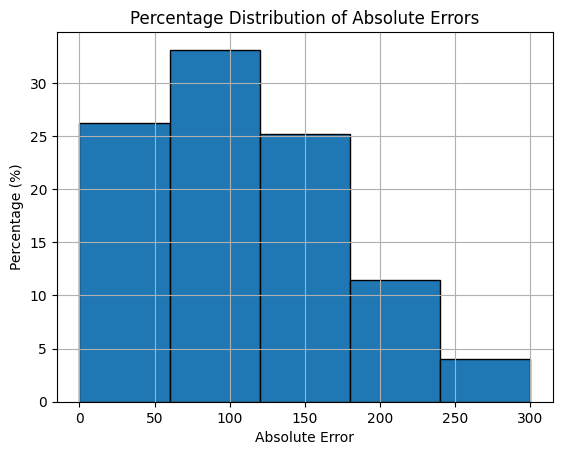

In [56]:
#evaluate
err = evaluate_model(model, test_loader, device)
plot_accuracy(err, bins = 5, min_range = 0, max_range = 300)

In [57]:
#Testing other optimizers (Adagrad is very efficient for our sparse data)
optimizer = torch.optim.Adagrad(model.parameters())
epochs=30

run_training(model, optimizer, criterion, device, epochs, train_loader, val_loader)
err = evaluate_model(model, test_loader, device)
plot_accuracy(err, bins = 5, min_range = 0, max_range = 300)

Epoch 13 (Train):  40%|████      | 12/30 [00:09<00:14,  1.21it/s, loss=37583.840]    


KeyboardInterrupt: 

## Training utility

In [ ]:
epochs = 20
for epoch in range(epochs):
    model.train()
    train_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device).float()
        y_batch = y_batch.to(device).float()
        
        preds = model(X_batch)
        loss = criterion(preds, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val = X_val.to(device).float()
            y_val = y_val.to(device).float()

            val_preds = model(X_val)
            val_loss += criterion(val_preds, y_val).item()

    print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(val_loader):.4f}")
